## Select number of iterations

In [1]:
nb_seed = 1

## Prior for RS+RFD

In [2]:
prior = 'Correct' # priors perturbed with standard DP Laplace mechanism
# prior = 'Incorrect_ZIPF' # priors following Zipf distribution 
# prior = 'Incorrect_DIR' # priors following Dirichlet distribution 
# prior = 'Incorrect_EXP' # priors following Exponential distribution

## Number of compromised profiles

In [3]:
attack = 'PK'
train_size = 0.1 # training size (nb of compromised profiles)

## Functions to save results in csv format per method

In [4]:
def write_attack_pk_rs_fd_grr(values):
    with open('results/acs/'+str(attack)+'_nk_'+str(train_size)+'_'+prior+'_rs_rfd_grr.csv', mode='a', newline='') as scores_file:
        scores_writer = csv.writer(scores_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
        scores_writer.writerow(values)
    scores_file.close()     

def write_attack_pk_rs_fd_oue_r(values):
    with open('results/acs/'+str(attack)+'_nk_'+str(train_size)+'_'+prior+'_rs_rfd_oue_r.csv', mode='a', newline='') as scores_file:
        scores_writer = csv.writer(scores_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
        scores_writer.writerow(values)
    scores_file.close() 
        
def write_attack_pk_rs_fd_sue_r(values):
    with open('results/acs/'+str(attack)+'_nk_'+str(train_size)+'_'+prior+'_rs_rfd_sue_r.csv', mode='a', newline='') as scores_file:
        scores_writer = csv.writer(scores_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
        scores_writer.writerow(values)
    scores_file.close()          

## Numba library for speeding up things

In [5]:
from numba import jit

## GRR function

In [6]:
@jit(nopython=True)
def GRR(x, lst_val, p, q):
    """
    GRR mechanism
    input: true value x, domain values 'lst_val', and probabilities p,q
    output: true value w.p. 'p', random value (except x) w.p. 'q'
    """
    
    rnd = np.random.random()

    if rnd <=p:    
        return x
    else:
        return np.random.choice(lst_val[lst_val !=x]) 

## UE function

In [7]:
@jit(nopython=True)
def UE(arr, p, q):
    """
    UE mechanism
    input: encoded true value arr and probabilities p and q
    output: sanitized array 'rep'
    """
    
    size = len(arr) #domain size
    rep = np.zeros(size) # initialize zero-vector
    
    for ind in range(size): # for each bit
        if arr[ind] != 1:
            rnd = np.random.random()
            if rnd <= q:
                rep[ind] = 1       
        else:
            rnd = np.random.random()
            if rnd <= p:
                rep[ind] = 1
    return rep

## Main libraries

In [8]:
import warnings; warnings.simplefilter('ignore')
import pandas as pd; pd.set_option('mode.chained_assignment',None)
import numpy as np

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
import copy
import time
import csv
from pandas.core.common import flatten

#ML
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier

from diffprivlib.mechanisms import Laplace

## Reading dataset

In [9]:
df = pd.read_csv('db_ACSEmployement.csv')
df

,AGEP,SCHL,MAR,SEX,DIS,ESP,MIG,CIT,MIL,ANC,NATIVITY,RELP,DEAR,DEYE,DREM,RAC1P,GCL,ESR
0,61,16.0,3,1,2,-99999.0,1.0,1,4.0,1,1,16,2,2,2.0,1,2.0,6.0
1,57,17.0,3,1,1,-99999.0,3.0,1,4.0,1,1,16,2,2,1.0,1,2.0,6.0
2,18,19.0,5,2,2,-99999.0,3.0,1,4.0,2,1,17,2,2,2.0,1,-99999.0,6.0
3,28,14.0,3,1,1,-99999.0,1.0,1,2.0,1,1,16,2,2,1.0,1,-99999.0,6.0
4,18,16.0,5,2,1,-99999.0,3.0,1,4.0,2,1,17,2,1,2.0,9,-99999.0,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10331,15,13.0,5,2,2,-99999.0,1.0,1,-99999.0,2,1,7,2,2,2.0,1,-99999.0,-99999.0
10332,65,18.0,5,1,2,-99999.0,1.0,1,4.0,1,1,0,2,2,2.0,3,2.0,3.0
10333,46,21.0,1,1,2,-99999.0,1.0,1,4.0,1,1,0,2,2,2.0,1,2.0,1.0
10334,46,16.0,1,2,2,-99999.0,1.0,1,4.0,1,1,1,2,2,2.0,1,2.0,1.0


## Dataset to work with

In [10]:
attributes = list(df.columns)

LE = LabelEncoder()

for col in attributes:
    df[col] = LE.fit_transform(df[col])
df

,AGEP,SCHL,MAR,SEX,DIS,ESP,MIG,CIT,MIL,ANC,NATIVITY,RELP,DEAR,DEYE,DREM,RAC1P,GCL,ESR
0,61,16,2,0,1,0,1,0,4,0,0,16,1,1,2,0,2,5
1,57,17,2,0,0,0,3,0,4,0,0,16,1,1,1,0,2,5
2,18,19,4,1,1,0,3,0,4,1,0,17,1,1,2,0,0,5
3,28,14,2,0,0,0,1,0,2,0,0,16,1,1,1,0,0,5
4,18,16,4,1,0,0,3,0,4,1,0,17,1,0,2,8,0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10331,15,13,4,1,1,0,1,0,0,1,0,7,1,1,2,0,0,0
10332,65,18,4,0,1,0,1,0,4,0,0,0,1,1,2,2,2,3
10333,46,21,0,0,1,0,1,0,4,0,0,0,1,1,2,0,2,1
10334,46,16,0,1,1,0,1,0,4,0,0,1,1,1,2,0,2,1


## Static parameters

In [11]:
#number of dimensions (d)
d = len(attributes)
print('d=', d)

#number of users (n)
n = df.shape[0]
print('n=',n)

#sampling rate
beta = 1/d
print('beta=', beta)

#domain size of attributse
lst_k = [len(df[att].unique()) for att in attributes]
print('Domain size of attributes =', lst_k)

#range of epsilon used in experiments
lst_eps = list(range(1, 11))
print('epsilon=', lst_eps)

d= 18
n= 10336
beta= 0.05555555555555555
Domain size of attributes = [92, 25, 5, 2, 2, 9, 4, 5, 5, 4, 2, 18, 2, 2, 3, 9, 3, 6]
epsilon= [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]


## Real frequency

In [12]:
# For each attribute, count the number of people per value

dic_true = {att:{val:0 for val in np.unique(df[att])} for att in attributes}

for att in attributes:

    dfcp = df.groupby(att).count()
    n = df.shape[0]

    index = 0
    for val in dfcp.index:
        val_true = dfcp.values[index,0]
        dic_true[att][val] += val_true 
        index+=1
dic_true

{'AGEP': {0: 89,
  1: 83,
  2: 108,
  3: 105,
  4: 108,
  5: 120,
  6: 111,
  7: 124,
  8: 121,
  9: 141,
  10: 132,
  11: 132,
  12: 111,
  13: 131,
  14: 125,
  15: 122,
  16: 122,
  17: 127,
  18: 131,
  19: 118,
  20: 101,
  21: 83,
  22: 92,
  23: 86,
  24: 108,
  25: 84,
  26: 123,
  27: 98,
  28: 94,
  29: 109,
  30: 128,
  31: 132,
  32: 96,
  33: 91,
  34: 130,
  35: 109,
  36: 117,
  37: 118,
  38: 95,
  39: 109,
  40: 119,
  41: 103,
  42: 105,
  43: 92,
  44: 104,
  45: 88,
  46: 93,
  47: 122,
  48: 114,
  49: 107,
  50: 94,
  51: 110,
  52: 114,
  53: 125,
  54: 148,
  55: 144,
  56: 156,
  57: 158,
  58: 196,
  59: 194,
  60: 199,
  61: 175,
  62: 205,
  63: 180,
  64: 171,
  65: 191,
  66: 187,
  67: 169,
  68: 161,
  69: 144,
  70: 168,
  71: 138,
  72: 122,
  73: 111,
  74: 102,
  75: 97,
  76: 114,
  77: 77,
  78: 77,
  79: 78,
  80: 73,
  81: 55,
  82: 53,
  83: 51,
  84: 38,
  85: 39,
  86: 36,
  87: 40,
  88: 22,
  89: 23,
  90: 23,
  91: 67},
 'SCHL': {0: 280,
  

## RS+RFD[GRR]

In [13]:
starttime = time.time()

dic_rsfd_grr = {} # initialize dictionary to save df result per epsilon

for my_seed in range(nb_seed):
    print(my_seed)
    np.random.seed(my_seed)

    lst_acc = []
    for epsilon_tot in lst_eps: #iterate over each epsilon value

        dic_id = {key:[] for key in range(n)}

        freq_prior = []

        LAP_MECH = Laplace(epsilon=0.1/d, sensitivity=1)

        for att in attributes:
            freq = np.array([int(np.rint(LAP_MECH.randomise(val)).clip(0)) for val in dic_true[att].values()])
            freq = freq/sum(freq) # census de l'annee derniere

            freq_prior.append(freq)

        eps_l = np.log((np.exp(epsilon_tot) - 1 + beta)/beta) #amplification by sampling

        # we'll shuffle the users' order in the dataset
        dff = df.sample(frac=1)     
        dff.reset_index(drop=True, inplace=True)

        # we'll partitionate the users indexes to separate in groups (i.e., to report a single attribute)
        lst_index = [list(_) for _ in np.array_split(dff.index, d)]

        for index_att in range(d): # for each attribute

            att = attributes[index_att]

            k = lst_k[index_att]

            lst_val = np.arange(k) # take domain values of the attribute

            # select users that report the true value of this attribute (i.e., not fake data)
            lst_true = {key:val for key, val in dff.iloc[lst_index[index_att]][att].iteritems()} #list(dff.iloc[lst_index[index_att]][att])

            # GRR parameters with amplified epsilon (eps_l)
            p = np.exp(eps_l) / (np.exp(eps_l) + k - 1) 
            q = (1 - p) / (k - 1)

            for usr_id in dic_id.keys():

                if usr_id in lst_index[index_att]:
                    dic_id[usr_id].append(GRR(lst_true[usr_id], lst_val, p, q))

                else:
                    dic_id[usr_id].append(np.random.choice(lst_val, p=freq_prior[index_att]))

        lst_label = [i for i in range(d) for _ in range(len(lst_index[i]))]
        df_syn = pd.DataFrame.from_dict(dic_id.values())
        df_syn.columns = attributes 
        df_syn['Smp_Att'] = lst_label
        df_syn = df_syn.sample(frac=1)
        df_syn.reset_index(drop=True, inplace=True)

        # Attacking part
        X = df_syn.drop('Smp_Att', axis = 1)
        y = df_syn['Smp_Att']

        x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=1-train_size, random_state=my_seed)#, stratify=y

        model = XGBClassifier(random_state=my_seed, n_jobs=-1, eval_metric='mlogloss')
        model.fit(x_train, y_train)

        y_pred = model.predict(x_test)
        acc = round(accuracy_score(y_test,y_pred)*100, 2)
        lst_acc.append(acc)

    dic_rsfd_grr[my_seed] = lst_acc
    #write results in csv format 
    write_attack_pk_rs_fd_grr(list(flatten([my_seed, lst_acc])))
    
print('That took {} seconds'.format(time.time() - starttime))    

0
That took 75.10571575164795 seconds


## RS+FD[OUE-R]

In [14]:
starttime = time.time()
    
# initialize dictionary to save MSE result per epsilon
dic_rsfd_oue_r = {} 

for my_seed in range(nb_seed):
    print(my_seed)
    np.random.seed(my_seed)

    lst_acc = []

    for epsilon_tot in lst_eps: #iterate over each epsilon value

        dic_id = {key:[] for key in range(n)}

        freq_prior = []

        LAP_MECH = Laplace(epsilon=0.1/d, sensitivity=1)

        for att in attributes:
            freq = np.array([int(np.rint(LAP_MECH.randomise(val)).clip(0)) for val in dic_true[att].values()])
            freq = freq/sum(freq)

            freq_prior.append(freq)

        eps_l = np.log((np.exp(epsilon_tot) - 1 + beta)/beta) #amplification by sampling

        # we'll shuffle the users' order in the dataset
        dff = df.sample(frac=1)    
        dff.reset_index(drop=True, inplace=True)

        # we'll partitionate the users indexes to separate in groups (i.e., to report a single attribute)
        lst_index = [list(_) for _ in np.array_split(dff.index, d)]

        # given epsilon, initialize a list to save MSE result per attribute
        lst_mse_att = []

        for index_att in range(d): # for each attribute

            att = attributes[index_att]

            k = lst_k[index_att]

            lst_val = np.eye(k) # take domain values of the attribute

            # select users that report the true value of this attribute (i.e., not fake data)
            lst_true = {key:val for key, val in dff.iloc[lst_index[index_att]][att].iteritems()} 

            # OUE parameters with amplified epsilon (eps_l)
            p = 1/2
            q = 1 / (np.exp(eps_l) + 1)

            # randomize data of 'real' users and generate fake data for the rest
            for usr_id in dic_id.keys():

                if usr_id in lst_index[index_att]:
                    dic_id[usr_id].append(UE(lst_val[lst_true[usr_id]], p, q))

                else:
                    dic_id[usr_id].append(UE(lst_val[np.random.choice(range(k), p=freq_prior[index_att])], p, q))

        # create label column, i.e., the sampled attribute
        lst_label = [i for i in range(d) for _ in range(len(lst_index[i]))]
        df_syn = pd.DataFrame.from_dict([np.concatenate(dic_id[val]) for val in range(n)])
    #         df_syn.columns = attributes 
        df_syn['Smp_Att'] = lst_label
        df_syn = df_syn.sample(frac=1)
        df_syn.reset_index(drop=True, inplace=True)

        # Attacking part
        X = df_syn.drop('Smp_Att', axis = 1)
        y = df_syn['Smp_Att']

        x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=1-train_size, random_state=my_seed)#, stratify=y

        model = XGBClassifier(random_state=my_seed, n_jobs=-1, eval_metric='mlogloss')
        model.fit(x_train, y_train)

        y_pred = model.predict(x_test)
        acc = round(accuracy_score(y_test,y_pred)*100, 2)
        lst_acc.append(acc)

    dic_rsfd_oue_r[my_seed] = lst_acc

    #write results in csv format 
    write_attack_pk_rs_fd_oue_r(list(flatten([my_seed, lst_acc])))
        
print('That took {} seconds'.format(time.time() - starttime))    

0
That took 117.92166066169739 seconds


## RS+FD[SUE-R]

In [15]:
starttime = time.time()
    
# initialize dictionary to save MSE result per epsilon
dic_rsfd_oue_r = {} 

for my_seed in range(nb_seed):
    print(my_seed)
    np.random.seed(my_seed)

    lst_acc = []

    for epsilon_tot in lst_eps: #iterate over each epsilon value

        dic_id = {key:[] for key in range(n)}

        freq_prior = []

        LAP_MECH = Laplace(epsilon=0.1/d, sensitivity=1)

        for att in attributes:
            freq = np.array([int(np.rint(LAP_MECH.randomise(val)).clip(0)) for val in dic_true[att].values()])
            freq = freq/sum(freq)

            freq_prior.append(freq)

        eps_l = np.log((np.exp(epsilon_tot) - 1 + beta)/beta) #amplification by sampling

        # we'll shuffle the users' order in the dataset
        dff = df.sample(frac=1)    
        dff.reset_index(drop=True, inplace=True)

        # we'll partitionate the users indexes to separate in groups (i.e., to report a single attribute)
        lst_index = [list(_) for _ in np.array_split(dff.index, d)]

        # given epsilon, initialize a list to save MSE result per attribute
        lst_mse_att = []

        for index_att in range(d): # for each attribute

            att = attributes[index_att]

            k = lst_k[index_att]

            lst_val = np.eye(k) # take domain values of the attribute

            # select users that report the true value of this attribute (i.e., not fake data)
            lst_true = {key:val for key, val in dff.iloc[lst_index[index_att]][att].iteritems()} 

            # SUE parameters with amplified epsilon (eps_l)
            p = np.exp(eps_l/2) / (np.exp(eps_l/2) + 1)
            q = 1 / (np.exp(eps_l/2) + 1)

            # randomize data of 'real' users and generate fake data for the rest
            for usr_id in dic_id.keys():

                if usr_id in lst_index[index_att]:
                    dic_id[usr_id].append(UE(lst_val[lst_true[usr_id]], p, q))

                else:
                    dic_id[usr_id].append(UE(lst_val[np.random.choice(range(k), p=freq_prior[index_att])], p, q))

        # create label column, i.e., the sampled attribute
        lst_label = [i for i in range(d) for _ in range(len(lst_index[i]))]
        df_syn = pd.DataFrame.from_dict([np.concatenate(dic_id[val]) for val in range(n)])
    #         df_syn.columns = attributes 
        df_syn['Smp_Att'] = lst_label
        df_syn = df_syn.sample(frac=1)
        df_syn.reset_index(drop=True, inplace=True)

        # Attacking part
        X = df_syn.drop('Smp_Att', axis = 1).values.astype('uint8')
        y = df_syn['Smp_Att'].values.astype('uint8')

        x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=1-train_size, random_state=my_seed)#, stratify=y

        model = XGBClassifier(random_state=my_seed, n_jobs=-1, eval_metric='mlogloss')
        model.fit(x_train, y_train)

        y_pred = model.predict(x_test)
        acc = round(accuracy_score(y_test,y_pred)*100, 2)
        lst_acc.append(acc)

    dic_rsfd_oue_r[my_seed] = lst_acc

    #write results in csv format 
    write_attack_pk_rs_fd_sue_r(list(flatten([my_seed, lst_acc])))
        
print('That took {} seconds'.format(time.time() - starttime))    

0
That took 109.11862063407898 seconds


## Plotting results

In [16]:
import warnings; warnings.simplefilter('ignore')
import numpy as np

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
params = {'axes.titlesize':'18',
          'xtick.labelsize':'18',
          'ytick.labelsize':'18',
          'font.size':'18',
          'legend.fontsize':'medium',
          'lines.linewidth':'2.5',
          'font.weight':'normal',
          'lines.markersize':'14'
          }
matplotlib.rcParams.update(params)
plt.rcParams["mathtext.fontset"] = "cm"
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

In [17]:
fig_size = (10, 4)
font_x = 24
font_y = 20
dataset='acs'

(1, 10)
(1, 10)
(1, 10)


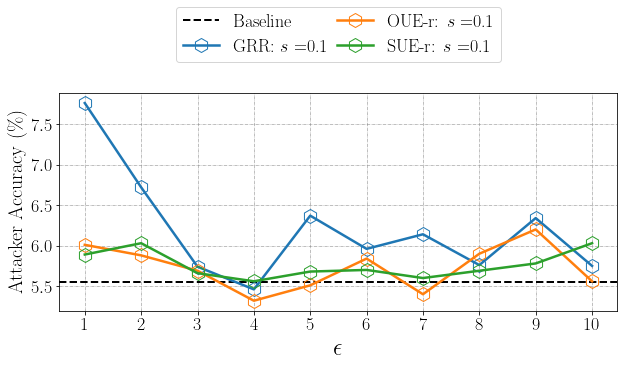

In [19]:
lst_nk = [0.1] # [0.1, 0.3, 0.5]

plt.figure(figsize=fig_size)
plt.grid(color='grey', linestyle='dashdot', linewidth=0.5)
plt.axhline(y=(1/d)*100, linewidth=2, color='black', label='Baseline', linestyle ='--')
    
markers = ['h', 's', 'v']

for idx in range(len(lst_nk)):
    attack_grr = pd.read_csv('results/'+dataset+'/'+str(attack)+'_nk_'+str(lst_nk[idx])+'_'+prior+'_rs_rfd_grr.csv', header=None, index_col=0)
    print(attack_grr.shape)
    plt.plot(range(1,len(lst_eps)+1), attack_grr.mean(), label='GRR: $s=$'+str(lst_nk[idx]), marker=markers[idx], markerfacecolor='none')
    
    attack_oue_r = pd.read_csv('results/'+dataset+'/'+str(attack)+'_nk_'+str(lst_nk[idx])+'_'+prior+'_rs_rfd_oue_r.csv', header=None, index_col=0)
    plt.plot(range(1,len(lst_eps)+1), attack_oue_r.mean(), label='OUE-r: $s=$'+str(lst_nk[idx]), marker=markers[idx], markerfacecolor='none')
    print(attack_oue_r.shape)
    
    attack_sue_r = pd.read_csv('results/'+dataset+'/'+str(attack)+'_nk_'+str(lst_nk[idx])+'_'+prior+'_rs_rfd_sue_r.csv', header=None, index_col=0)
    plt.plot(range(1,len(lst_eps)+1), attack_sue_r.mean(), label='SUE-r: $s=$'+str(lst_nk[idx]), marker=markers[idx], markerfacecolor='none')
    print(attack_sue_r.shape)
    
    plt.xlabel('$\epsilon$', fontsize=font_x)
    plt.ylabel('Attacker Accuracy (\%)', fontsize=font_y)
    plt.xticks(range(1,len(lst_eps)+1), lst_eps)
    idx+=1
plt.legend(bbox_to_anchor=(0.5, 1.1), columnspacing=0.5, ncol=2, loc='lower center')
# plt.savefig("fig_RSpRFD_NK_grr_"+dataset+".pdf", dpi=500, bbox_inches = 'tight',pad_inches = 0.1)
plt.show()

Please execute with more seeds for more stable plots